# Corona Virus Infections


**Please note:** _I am not an epidemiologist, scientist or public health professional. I don't know shit. These calculations are an experiment, they may be wrong by a signficant amount and should not be used as a basis for decision making._

**If you have any feedback or suggestions:** please create an issue or PR on github at [samuelcolvin/covid-19-calcs](https://github.com/samuelcolvin/covid-19-calcs).

I'm sitting around in Wiltshire self-isolating and getting frustrated by the media's insistence on using the number of confirmed cases as a corner stone of their coverage of COVID-19 (from here on CV), when that's clearly an aweful measure since the UK stopped testing most people ages ago.

Here's an altnernative way of calculating the number of cases: take the number of deaths (which is likely to be relatively accurate) and work back to guess how many people would have needed to be infected some time ago to cause that number of deaths. Use that as an estimate of the number of cases then. Projecting the number of deaths forward allows an estimate of the number of infectiosn today.

Assumptions and sources (more details of potential sources of error at the bottom of this document):
* deaths per day from CV by country form [our world in data](https://ourworldindata.org/coronavirus-source-data)
* **mortality rate: 0.9%** from [wikipedia](https://en.wikipedia.org/wiki/Coronavirus_disease_2019#cite_note-126) and in turn [this paper from imperial](https://web.archive.org/web/20200210105717/https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-2019-nCoV-severity-10-02-2020.pdf)
* average time from **contracting CV to death: 17** days from [this now infamous medium blog](https://medium.com/@tomaspueyo/coronavirus-act-today-or-people-will-die-f4d3d9cd99ca) which in turn seems to talk about [this](https://github.com/midas-network/COVID-19/tree/master/parameter_estimates/2019_novel_coronavirus#time-from-hospitalization-to-discharge) list of papers, doesn't make it clear exactly where that number comes from. This is really significant since slightly varying the time enormously impacts the estimated number of cases, see below.
* the number of cases and deaths is currently increasing exponentially in Europe, this appears to be a reasonably fit for the day. Exponential growth is a very good approximation for the beginning of a logistic curve, see [this excellent vidoe on logistic curves and exponential curves in relation to CV](https://www.youtube.com/watch?v=Kas0tIxDvrg)
* I'm looking just at cases in europe since I'm primarily interested in the UK and europe seems the most similer to the UK in terms of health services, willingness to institute draconian measures and knowledge of the virus. I'm not using just the UK since the small number of deaths (so far) makes estimating the best fit exponential curve difficult

Enough flirting, let's do some python:

In [1]:
# import some stuff and setup matplotlib (you can probably ignore all this)
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [16, 5]

In [2]:
# set some constants and download the raw data

# see discussion above
time_to_die = 17
# assuming a mortality rate of 0.9%
mortality_rate = 0.009
infection_multiple = 1 / mortality_rate

df_all = pd.read_csv('https://covid.ourworldindata.org/data/total_deaths.csv', parse_dates=['date'])
df_all = df_all.fillna(0).set_index('date')
latest_date = df_all.index[-1]
print(f'downloaded data on total deaths from {df_all.index[0]:%Y-%m-%d} to {latest_date:%Y-%m-%d}')

# from manually going through the above CSV, here are countries in europe. 
# It might not be perfect but it's good enough for this purpose
european_countries = [
    'Austria', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 
    'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Gibraltar', 'Greece', 'Guernsey', 'Hungary', 
    'Iceland', 'Ireland', 'Italy', 'Malta', 'Monaco', 'Netherlands', 'Norway', 'Poland', 'Portugal', 
    'Romania', 'San Marino', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 
    'Ukraine', 'United Kingdom', 'Vatican',
]
# add a new column with the number of deaths in the whole of europe
df_all['europe'] = sum(df_all[c] for c in european_countries)

# create a new dataframe with just the date column and number of deaths in europe as 'deaths_actual'
# we've also cut off the beginning of the dataframe since there were no deaths in europe before the 16th of Feb
df = df_all[['europe']].truncate(before=datetime(2020, 2, 15)).rename(columns={'europe': 'deaths_actual'})
# print out the raw table to make sure it makes sense
df

downloaded data on total deaths from 2020-01-21 to 2020-03-16


,deaths_actual
date,
2020-02-15,0.0
2020-02-16,1.0
2020-02-17,1.0
2020-02-18,1.0
2020-02-19,1.0
2020-02-20,1.0
2020-02-21,1.0
2020-02-22,1.0
2020-02-23,3.0


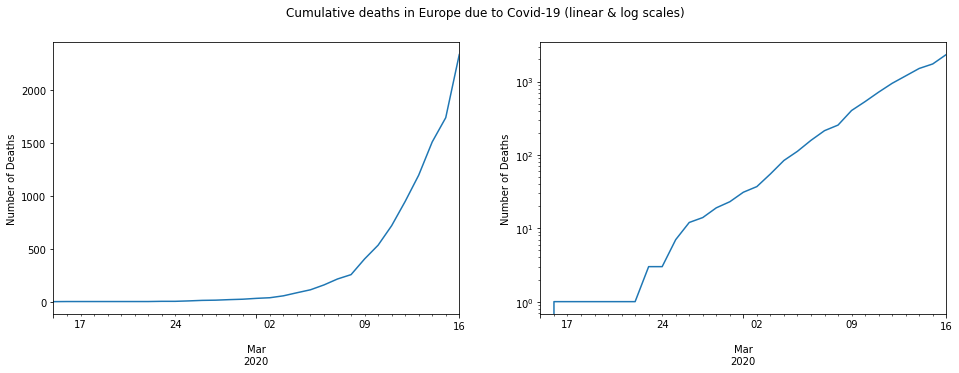

In [3]:
# set's set up a function to plot our results so we can reuse it
# (I'm a software developer not a data scientist if you hadn't already noticed)

def log_lin_plots(df, title, ylabel=None):
    """
    Plot the data from a linear and log scale with some title and optional label for the y axis
    """
    fig, axes = plt.subplots(ncols=2)
    fig.suptitle(f'{title} (linear & log scales)')
    legend = not ylabel
    df.plot(ax=axes[0], legend=legend)
    df.plot(logy=True, ax=axes[1], legend=legend)
    for ax in axes.flat:
        ax.set(ylabel=ylabel, xlabel=None)
    plt.show()

log_lin_plots(df, 'Cumulative deaths in Europe due to Covid-19', ylabel='Number of Deaths')

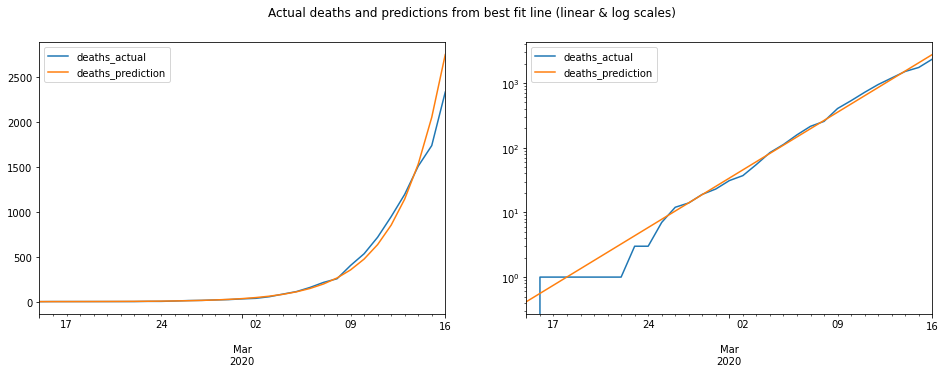

In [4]:
# let's fit an exponential curve to the data curve above

def to_day(ts):
    """
    Convert a timestamp into an integer. The actual magnitude of the number doesn't matter, 
    hence choosing the beginning of 2020 as epoch in this calculation.
    """
    return (ts.to_pydatetime() - datetime(2020, 1, 1)).days

# now eyeballing the numbers above, let's truncate the data to only doing the fitting on data
# from the 26th onwards when the curve can realistically be considered exponential 
# (the line on the log plot above is straight)
df_fit = df.truncate(before=datetime(2020, 2, 26))
# next, convert the timestamp index into ints
x = np.array([to_day(v) for v in df_fit.index])

# now we can use numpy.polyfit to do a simple linear regression (that's the 1 argument)
# against the log of the actual death numbers, you can think of this as simply a posh way
# of measuring the gradient (b) and y intercept (a) of the straight part of the line on the right above
b, log_a = np.polyfit(x, np.log(df_fit['deaths_actual']), 1)
a = np.exp(log_a)

def deaths_fit(day):
    """
    estimate total number of deaths on a given day based on a regression on the actual
    deaths each day
    """
    return a * np.exp(b * day)


# okay, let's see if our prediction looks like it's any good
# we're going to plot our prediction of the number of deaths against the actual numbers
days = np.array([to_day(v) for v in df.index])
df_predictions = pd.DataFrame(
    {'deaths_actual': df['deaths_actual'], 'deaths_prediction': deaths_fit(days)}, 
    index=df.index,
)

log_lin_plots(df_predictions, 'Actual deaths and predictions from best fit line')
# this looks over all like a pretty good match
# side note: Some postive news, I first than these numbers with data up to the 13th, since then
# the exponential curve has started to out strip the actual data. We could perhaps therefore tentatively
# start to suggest that europe has just begun to curb the rate of infection!

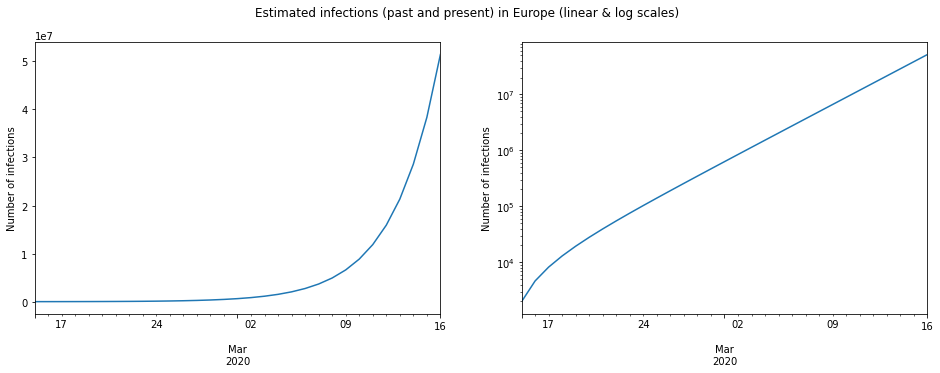

Estimated number of infections (past and present) in Europe on 2020-03-16: 51,422,925


In [5]:
# lots of messing around, now we can actually estimate the number of infections in Europe

def deaths_per_day(day):
    """
    Calculate the number of people who die on a given day by differentiating
    the above deaths fit equation. (I hope you remember your AS level maths!)
    """
    return a * b * np.exp(b * day)
    

def calc_infection(day):
    """
    Calculate the number of people infected on this day based on the number expected to die
    on some day in the future who contracted the virus on this day.
    """
    deaths_hence = deaths_per_day(day + time_to_die)
    return deaths_hence * infection_multiple

# to plot the estimate over time, calculate for every day in the time period we're using
df_infections = pd.DataFrame({'infections': np.cumsum(calc_infection(days))}, index=df.index)
log_lin_plots(df_infections, 'Estimated infections (past and present) in Europe', ylabel='Number of infections')

# and print out the number of estimated cases on the last day with data
europe_infections = df_infections['infections'][latest_date]
print(
    f'Estimated number of infections (past and present) in Europe on '
    f'{latest_date:%Y-%m-%d}: {europe_infections:0,.0f}'
)



In [6]:
# to estimate the number of infections in the UK (which is my (selfish) primary interest)
# I'm assuming the proportion of infections mirrors the proportion of deaths
latest_deaths_eu = df_all['europe'][latest_date]
latest_deaths_uk = df_all['United Kingdom'][latest_date]
print(
    f'There were {latest_deaths_eu:0,.0f} deaths in Europe on {latest_date:%Y-%m-%d} '
    f'and {latest_deaths_uk:0,.0f} in the UK'
)
uk_infections = europe_infections * latest_deaths_uk / latest_deaths_eu
print(f'Estimated number of infections (past and present) on {latest_date:%Y-%m-%d} in UK: {uk_infections:0,.0f}')

There were 2,333 deaths in Europe on 2020-03-16 and 35 in the UK
Estimated number of infections (past and present) on 2020-03-16 in UK: 771,454


# Sources of Uncertainty

There are a bunch of reasons these estimates might be wrong, primarily me making a mistake, but to be more precise about potential errors, I'll explain my thinking on the main ones.

### Number of deaths each day

There's no uncertainty whether someone has died, however:
* Uncertainty regarding the cause of death is real, but in the case of CV, should have a relatively small effect
* We could reasonably assume that the vast majority of those who die having shown any CV symptoms will have been tested
* countries intentionally not reporting deaths or having poor reporting, possible but unlikely in europe

### Mortality rate

Definitely hard to be certain above, but unlikely it's wrong by more than a factor of 2.

### Average time from Infection to Death

This is absolutely **critical** to this estimate and is very uncertain. 

Even a small variation in this number has a very big effect on the estimated number of current cases.
For example using 17 today (the 16th March) gives an estimate of 44.6m cases in europe, if you change that
from 17 to 14, the number of estimated cases drops to 18.5m.

The data source I'm using is not at all clear and the underlying papers show that this figure as a very wide
margin for error

### Assumption of Exponential grown

This could be wrong if:
* the number of cases reach a significant proportion of the population (say 20%?). It hasn't.
* efforts to reduce the number of cases become more effective. This could well be the case. We can perhaps
  see that starting to happen in the above

### Cumulative data

The data on the number of deaths is cumulative. To get the the number of people who die each day,
I'm taking the first derivative of the best fit function for total deaths. I'm then using
that figure to calculate the number of people who get infected each day.

I then talk about "infections" as either past or present (which currently won't be that different), since
the vast majority of people who ever had CV in europe still have it now.

I've two concerns:
* Is my differentiate then `cumsum` approach right?
* The calcs should be extended to show the number of people infected on a given day
